学習するたびに組み合わせを変えていく。

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Allocation GPU hardware ID = 0
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1], 'GPU')

2022-12-23 14:35:34.628749: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-23 14:35:38.381685: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-23 14:35:38.400149: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-23 14:35:39.543565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:84:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.665GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2022-12-23 14:35:39.543854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451

とりあえず、データセットの作り方を考える。

In [3]:
dir_name = "data_03" 
theta_s = [5 * i - 45 for i in range(19)]
phi_s   = [5 * i - 45 for i in range(19)]

file_names = [str(dir_name)+"/data"+str(theta)+","+str(phi)+".csv" for theta in theta_s for phi in phi_s]

data = [np.array(pd.read_csv(file_name)['dose']).reshape(61,61,150) for file_name in file_names]

data = np.array(data).astype("float32")
data = np.expand_dims(data, axis=4)

label = [(theta, phi) for theta in theta_s for phi in phi_s]

two-hotにする際には正解ラベルも正規化する。

In [4]:
t_label = []
p_label = []
for t,p in label:
    t_onehot = np.zeros(91)
    p_onehot = np.zeros(91)
    
    t_onehot[t] = 0.5
    p_onehot[p] = 0.5
    
    t_label.append(t_onehot)
    p_label.append(p_onehot)
t_label = np.array(t_label)
p_label = np.array(p_label)

labels = (t_label, p_label)

In [5]:
#Input shape の定義
inp_shape = (61, 61, 150, 1)
inputs = tf.keras.Input(shape = inp_shape)

# x = layer()(x)の形で層を定義していく
x = tf.keras.layers.Conv3D(16, 2, activation = 'relu', strides = 2, name = "conv3d_1")(inputs)
x = tf.keras.layers.BatchNormalization(name = "normalize_1")(x)

x = tf.keras.layers.Conv3D(32, 2, activation = 'relu', strides = 2, name = "conv3d_2")(x)
x = tf.keras.layers.BatchNormalization(name = "normalize_2")(x)

x = tf.keras.layers.Conv3D(64, 2, activation = 'relu', strides = 2, name = "conv3d_3")(x)

x = tf.keras.layers.Flatten(name = "flatten")(x)

# 出力層を複数にする場合は、出力層 = layer()(中間層)の形にする。
theta = tf.keras.layers.Dense(91, activation='softmax', name = "theta")(x)
phi = tf.keras.layers.Dense(91, activation='softmax'  , name = "phi"  )(x)

#ここで、modelのinputとoutputを定義する
model = tf.keras.Model(inputs=inputs, outputs=[theta, phi])

#出力層ごとにoptimizerやlossを変更できるが、全て同じで良い場合はひとつ設定すれば良い
model.compile(loss      = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(0.2))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 61, 61, 150, 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 30, 30, 75, 1 144         input_1[0][0]                    
__________________________________________________________________________________________________
normalize_1 (BatchNormalization (None, 30, 30, 75, 1 64          conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 15, 15, 37, 3 4128        normalize_1[0][0]                
______________________________________________________________________________________________

2022-12-23 14:36:23.017887: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 14:36:23.022745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2022-12-23 14:36:23.022793: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-23 14:36:23.022839: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-23 14:36:23.022871: I tensorflow/stream_executor/platform/

学習を行うたびにデータセットを変更していく。変更していくデータはランダムで決める。エポック数を小さめに設定することで、学習時間を短くした。

In [7]:
for nums in range(100):
    itr = np.random.randint(0, len(data), [256,2])
    x_train = np.array([data[i[0]] + data[i[1]] for i in itr])
    
    t_train = np.array([labels[0][i[0]] + labels[0][i[1]] for i in itr])
    p_train = np.array([labels[1][i[0]] + labels[1][i[1]] for i in itr])
    
    model.fit(x = x_train, y = {"theta":t_train, "phi":p_train},
          batch_size = 2**13,
          epochs     = 20)
    if nums % 20 == 0:
        model.save_weights("double_beam")
    print(nums)

Epoch 1/20
1/1 [==============================] - 1s 961ms/step - loss: 0.0678 - theta_loss: 0.0333 - phi_loss: 0.0344
Epoch 2/20
1/1 [==============================] - 0s 449ms/step - loss: 0.0670 - theta_loss: 0.0331 - phi_loss: 0.0339
Epoch 3/20
1/1 [==============================] - 0s 447ms/step - loss: 0.0667 - theta_loss: 0.0329 - phi_loss: 0.0338
Epoch 4/20
1/1 [==============================] - 0s 451ms/step - loss: 0.0664 - theta_loss: 0.0328 - phi_loss: 0.0336
Epoch 5/20
1/1 [==============================] - 0s 450ms/step - loss: 0.0662 - theta_loss: 0.0327 - phi_loss: 0.0335
Epoch 6/20
1/1 [==============================] - 0s 449ms/step - loss: 0.0660 - theta_loss: 0.0326 - phi_loss: 0.0333
Epoch 7/20
1/1 [==============================] - 0s 451ms/step - loss: 0.0657 - theta_loss: 0.0325 - phi_loss: 0.0332
Epoch 8/20
1/1 [==============================] - 0s 449ms/step - loss: 0.0656 - theta_loss: 0.0324 - phi_loss: 0.0331
Epoch 9/20
1/1 [==============================] 

In [8]:
itr = np.random.randint(0, len(data), [100,2])
x_test = np.array([data[i[0]] + data[i[1]] for i in itr])

t_pred = np.array([labels[0][i[0]] + labels[0][i[1]] for i in itr])
p_pred = np.array([labels[1][i[0]] + labels[1][i[1]] for i in itr])

pred_t, pred_p = model.predict(x_test)

In [9]:
import matplotlib.pyplot as plt

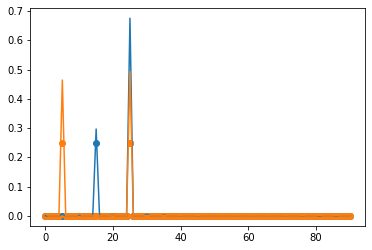

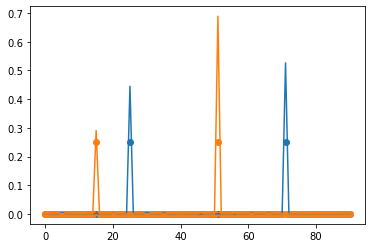

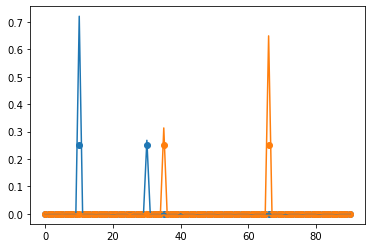

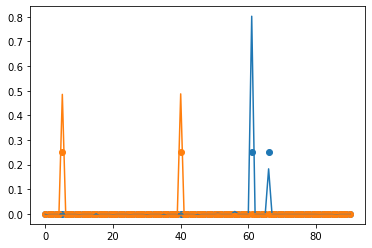

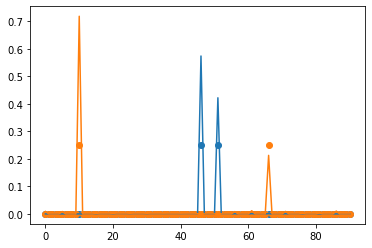

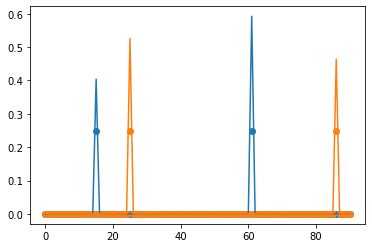

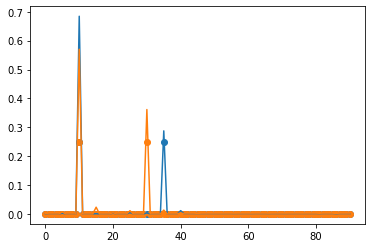

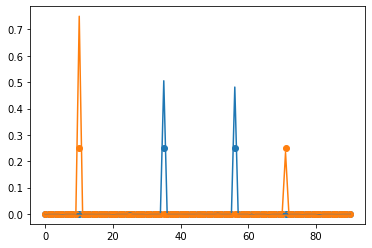

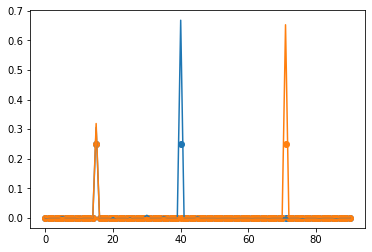

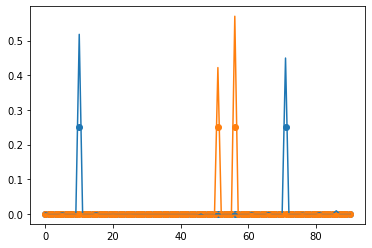

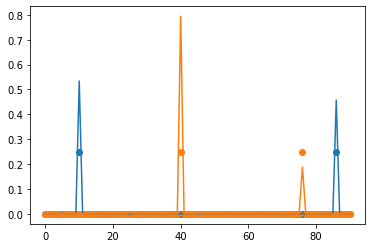

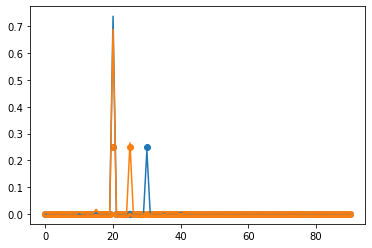

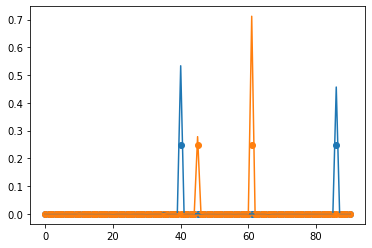

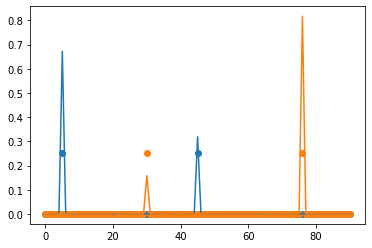

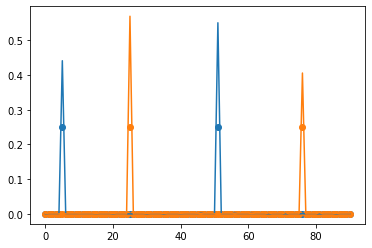

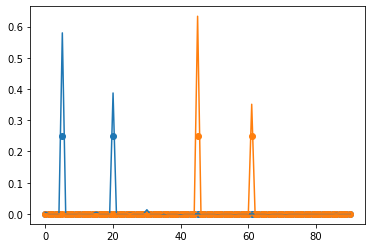

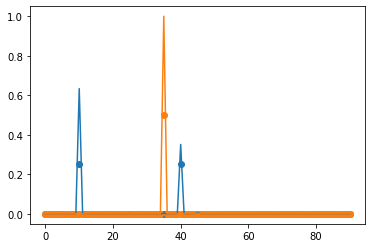

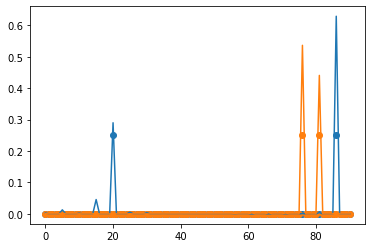

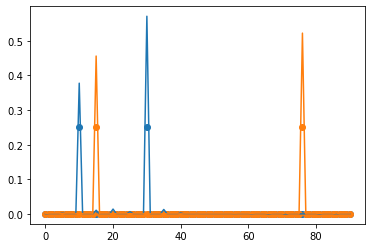

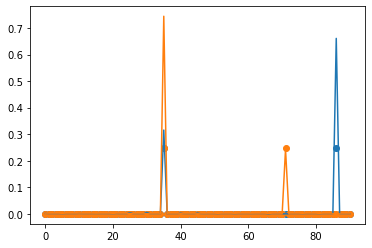

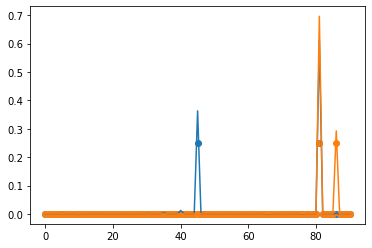

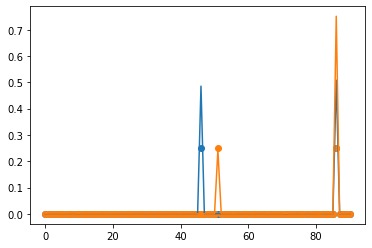

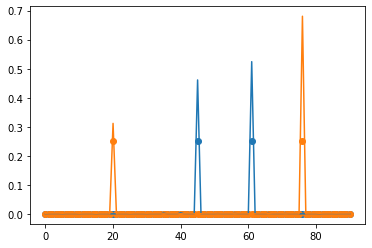

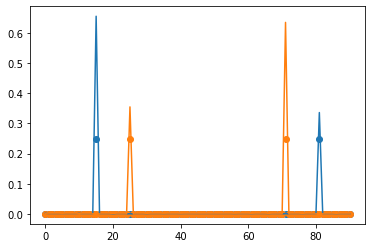

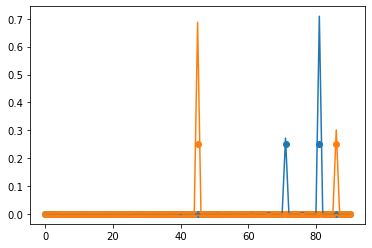

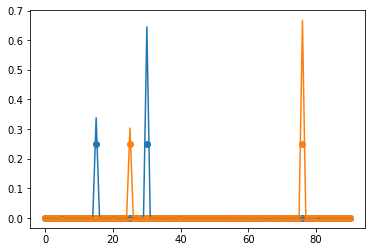

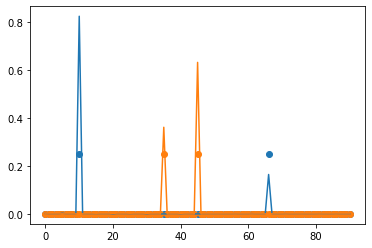

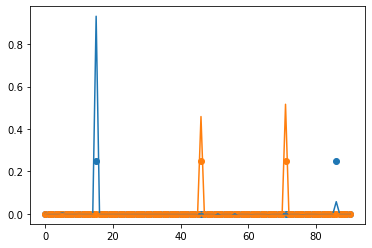

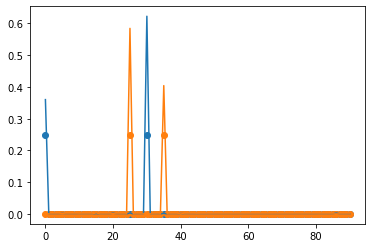

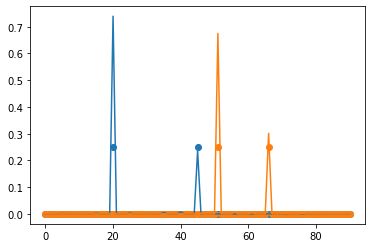

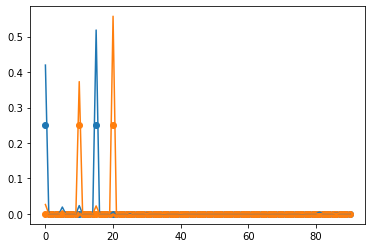

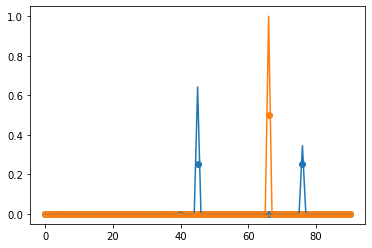

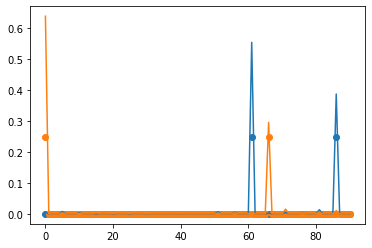

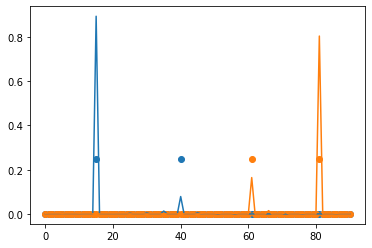

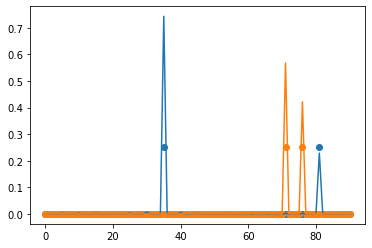

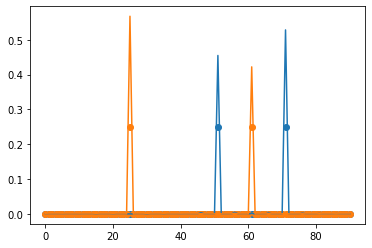

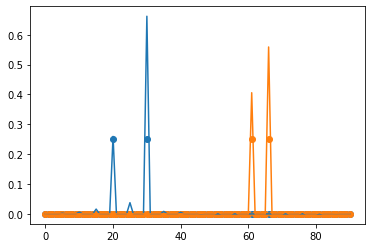

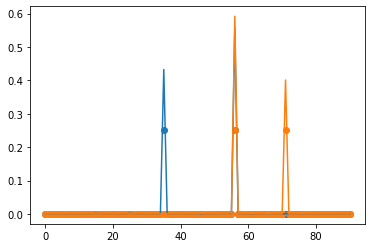

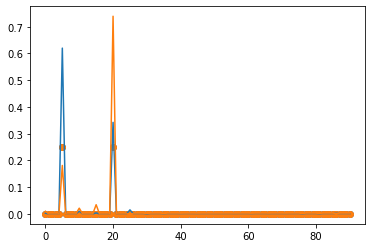

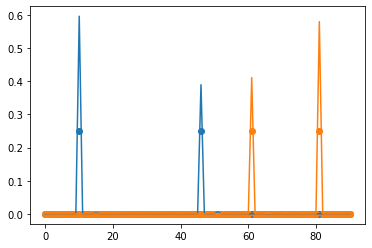

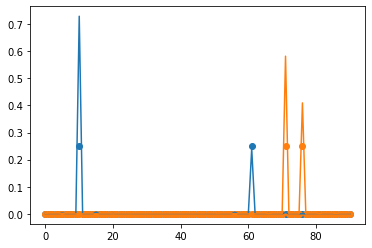

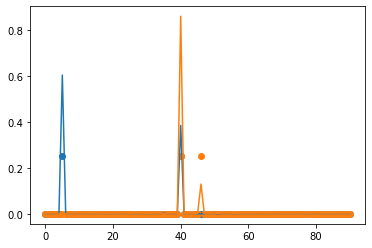

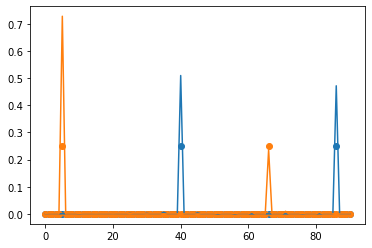

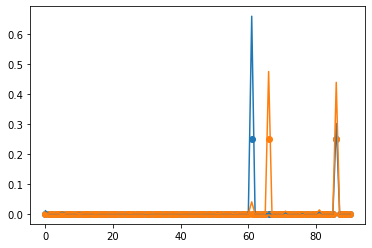

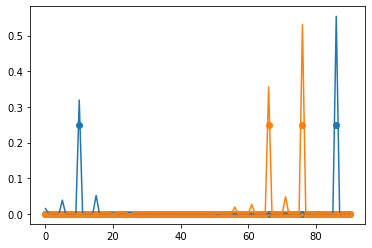

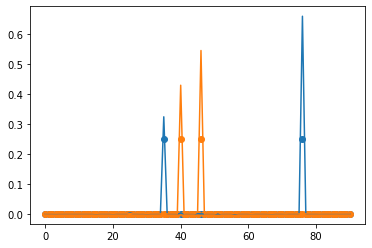

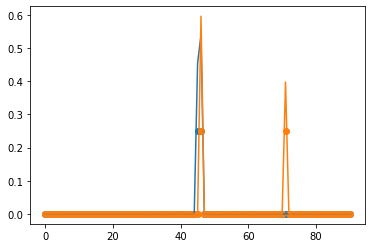

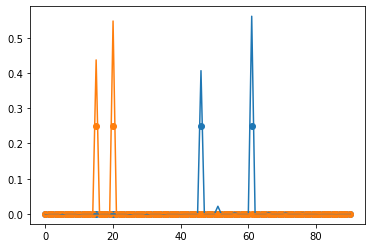

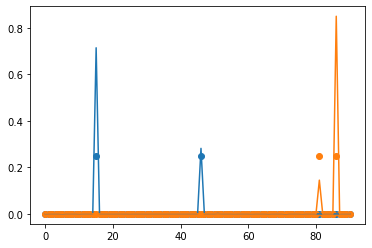

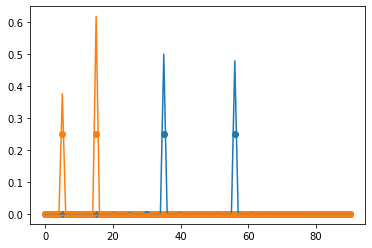

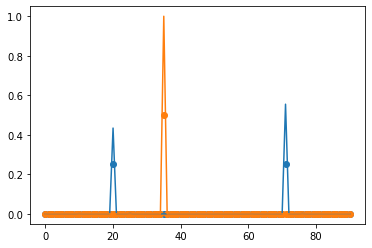

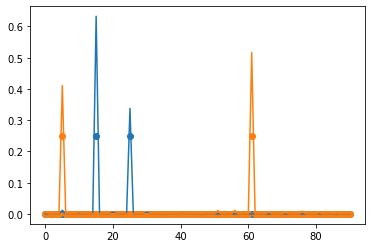

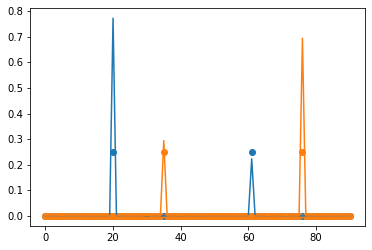

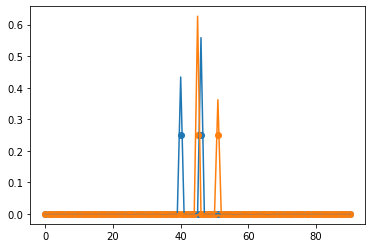

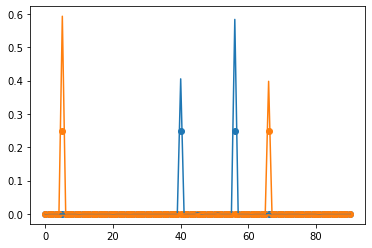

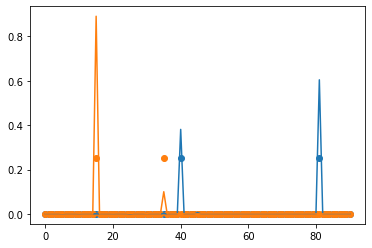

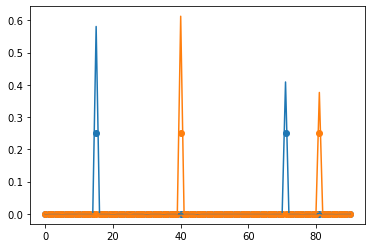

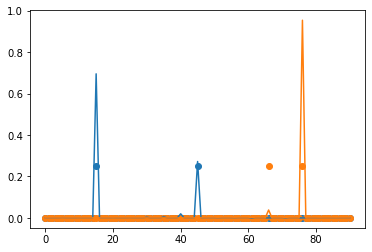

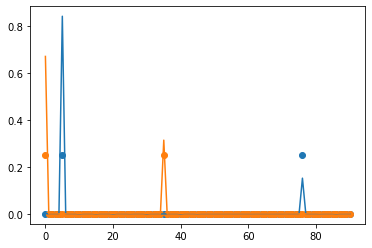

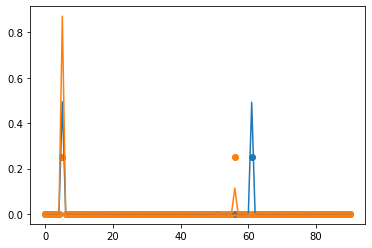

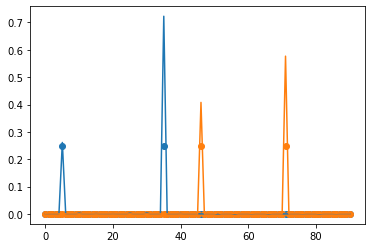

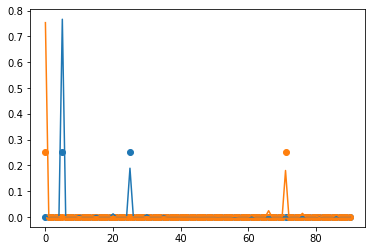

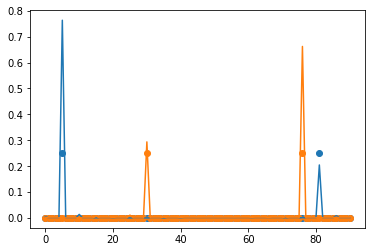

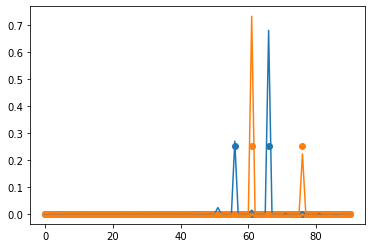

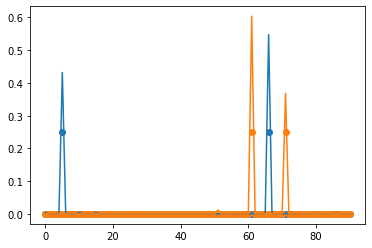

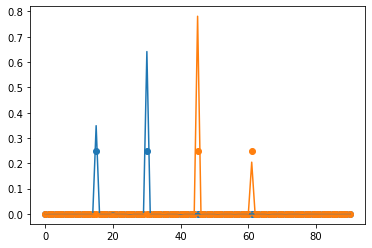

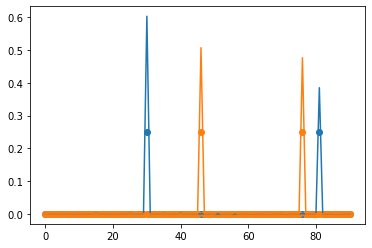

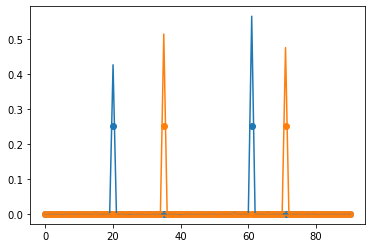

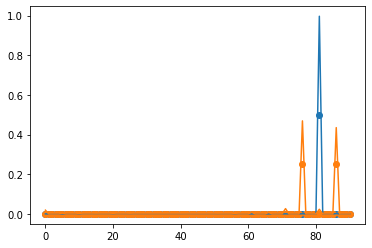

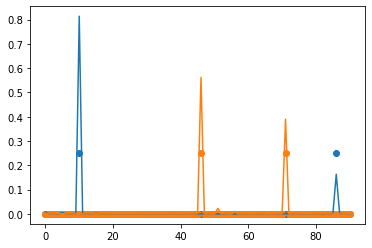

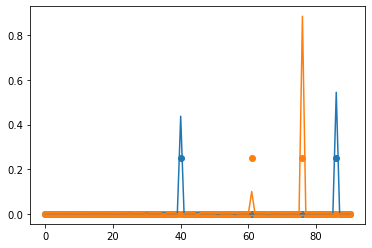

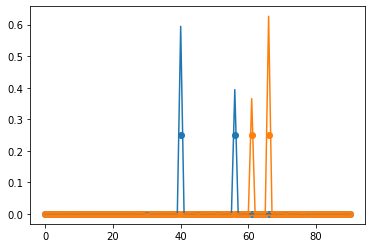

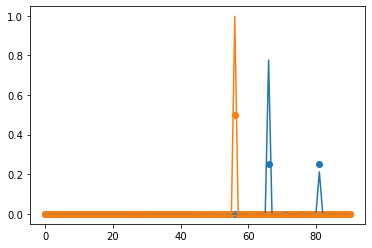

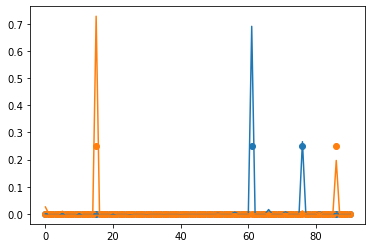

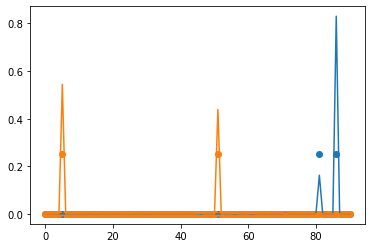

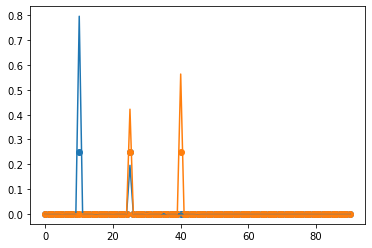

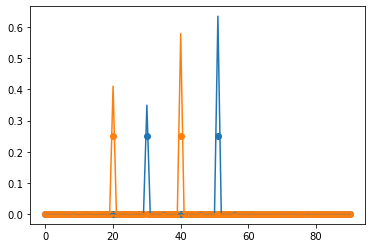

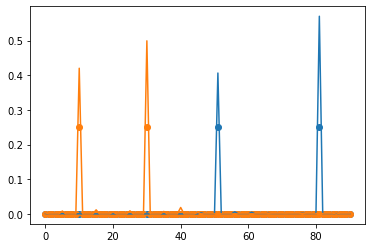

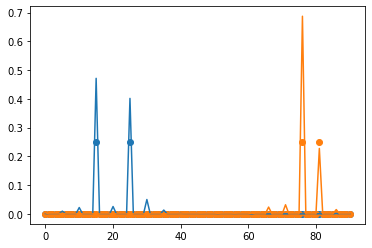

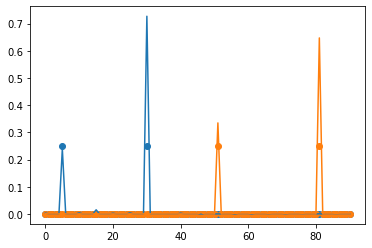

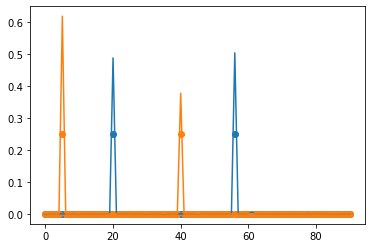

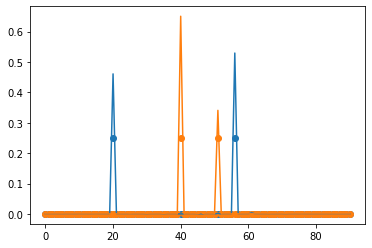

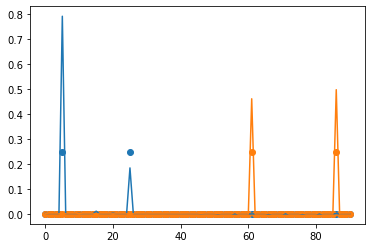

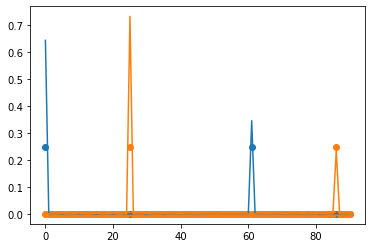

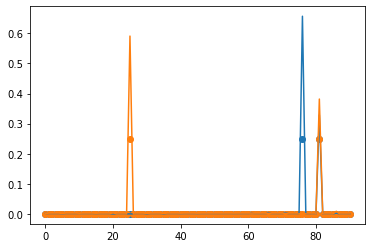

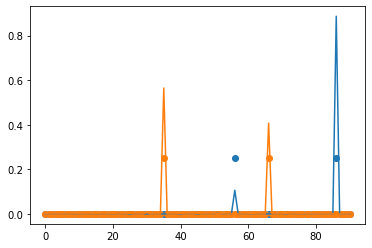

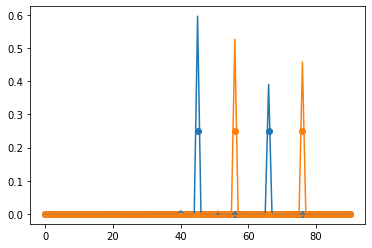

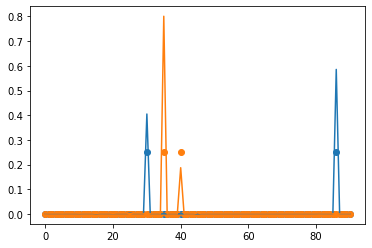

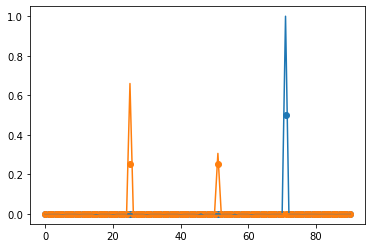

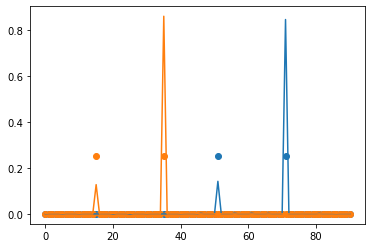

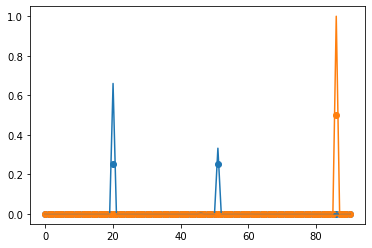

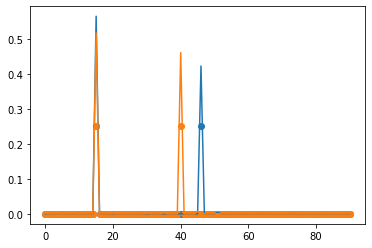

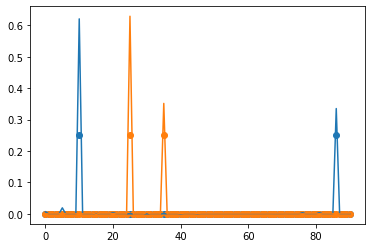

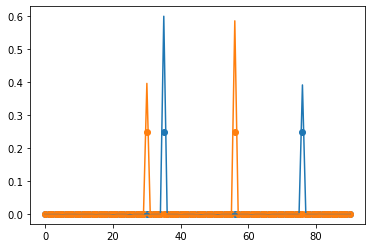

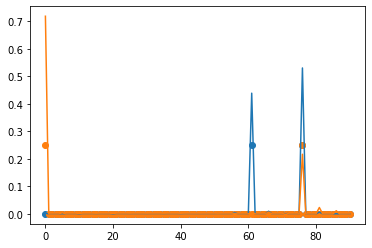

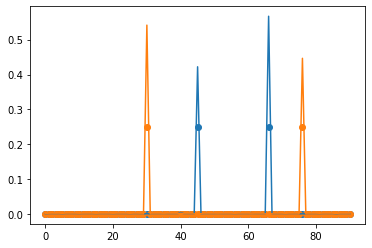

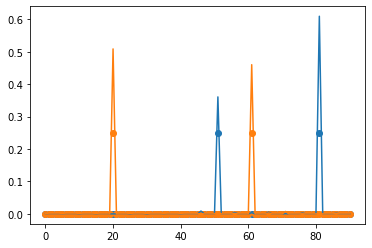

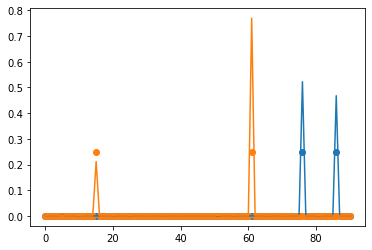

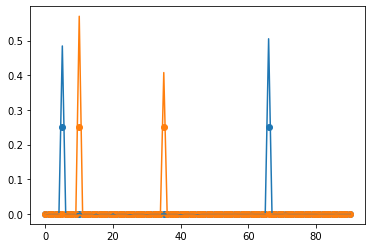

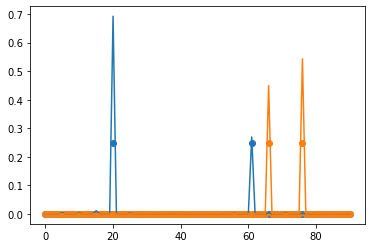

In [10]:
x = [i for i in range(91)]
for i in range(100):
    plt.plot(pred_t[i])
    plt.plot(pred_p[i])
    plt.scatter(x, 0.5 * t_pred[i])
    plt.scatter(x, 0.5 * p_pred[i])
    plt.show()
    plt.close()